In [80]:
import numpy as np
import random

In [81]:
import matplotlib.pyplot as plt 
import seaborn as sns

### CREATE A MAZE

In [115]:
class create_maze:
    def __init__(self, dimensions):
        self.rows = dimensions[0]
        self.cols = dimensions[1]
        self.maze = np.zeros((dimensions[0], dimensions[1]))
        
    # PLOT THE MAZE
    def plot(self):
        plt.figure(figsize=(6, 6))
        plt.show(sns.heatmap(self.maze, cmap='Dark2', cbar=False, linewidths=1))
        
    # CREATE FOOD AT A RANDOM POSITION
    def create_food(self):
        
        # FIND ALL EMPTY POSITIONS IN THE MATRIX
        positions = np.argwhere(self.maze == 0)
        
        # PICK A RANDOM OPEN INDEX
        index = random.randint(0, len(positions) - 1)
        
        # UPDATE THE MAZE
        self.update_maze(positions[index], 2)
    
    # UPDATE MAZE
    def update_maze(self, position, value):
        self.maze[position[0]][position[1]] = value

In [116]:
maze = create_maze([10, 10])

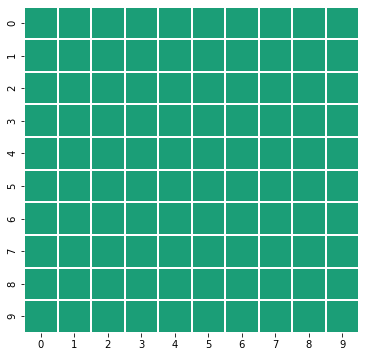

In [117]:
maze.plot()

In [118]:
for index in range(5):
    maze.create_food()

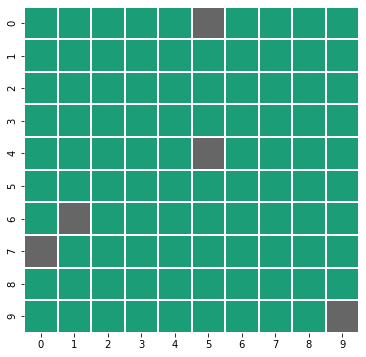

In [120]:
maze.plot()